In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import GraphHelpers as GH
%matplotlib inline

In [3]:
#Read in data
RawDrainageData=pd.read_csv('K:\Rainshelter\StonySoilLysimeters\DownloadedData\StonyLysimetersDrain.dat', #specify file path for data to read in
                         parse_dates=True, #tell the function to parse date columns to datetime formats
                         dayfirst=True, #tell the function that the day is before the year in the data i.e format='%d/%m/%Y %H:%M'
                         skiprows = [0,2,3], #leave out rows 1, 3 and 4 which have redundant information
                         index_col = 0, #Use the first column, which is Date, as an index
                         na_values = 'NAN')
#Drop empty columns
RawDrainageData.drop(['RECORD','BattV_Avg','PTemp_C_Avg','AirTC_Avg','RH_Max','SlrkW_Avg','SlrMJ_Tot','Rain_mm_Tot','WS_ms_Avg'],axis=1,inplace=True)

#Bring in all index data
DrainageDataIndex=pd.read_csv('.\IndexFiles\DrainageIndex.csv',
                         index_col = 0)
DrainageDataIndex = DrainageDataIndex.iloc[4:28,1:4]
#Apply indexes to data
DrainageDataTransposed = RawDrainageData.transpose()
DrainageDataIndexed = pd.concat([DrainageDataIndex,DrainageDataTransposed], axis=1)
DrainageDataIndexed.index.name='ColumnHeader',
#DrainageDataIndexed.set_index(['Measurement','Gravels','Stones','Column','Sensor', 'MUX', 'Port','Units','Summary','Block','Treatment'], 
#                        append=False, inplace=True)
DrainageDataIndexed.set_index(['Gravels','Stones','Treatment'], 
                        append=False, inplace=True)
DrainageDataIndexed.sort_index(inplace=True)
DrainageData=DrainageDataIndexed.transpose()
DrainageData.index = pd.to_datetime(DrainageData.index)  ## for some reason the concat function changes the data type on the date indes so need to change it back

In [4]:
GPs = GH.SetGraphicsPatterns(DrainageData.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['blue','green','red'])

Gravels
['Deep', 'Shallow']
Stones
['StoneFree', 'Stony', 'VeryStony']
Treatments
MultiIndex(levels=[['Deep', 'Shallow'], ['StoneFree', 'Stony', 'VeryStony']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]])
Styles
[('-', 'blue', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'red', 0.15, 'o'), ('--', 'blue', 0.45, '^'), ('--', 'green', 0.45, '^'), ('--', 'red', 0.45, '^')]
StyleFrame
                  Lin    Col   Alp Mar    MFC
Deep    StoneFree   -   blue  0.15   o   blue
        Stony       -  green  0.15   o  green
        VeryStony   -    red  0.15   o    red
Shallow StoneFree  --   blue  0.45   ^  white
        Stony      --  green  0.45   ^  white
        VeryStony  --    red  0.45   ^  white


In [5]:
ManualIndex = DrainageDataIndex
ManualIndex.set_index('Treatment', inplace=True)

In [6]:
ManualData = pd.read_excel('K:\Rainshelter\StonySoilLysimeters\Packing lysimeter drainage.xlsx',sheet_name = 'DrainageCondensed',index_col=0)
ManualData.columns.name='Treatment'
MD = pd.concat([ManualIndex,ManualData.transpose()],axis=1)
MD.set_index(['Gravels','Stones'],inplace=True)
ManualData = MD.transpose()
ManualData.sort_index(axis=1,inplace=True)

## Calibrate spoon tips against measured drainage volumes

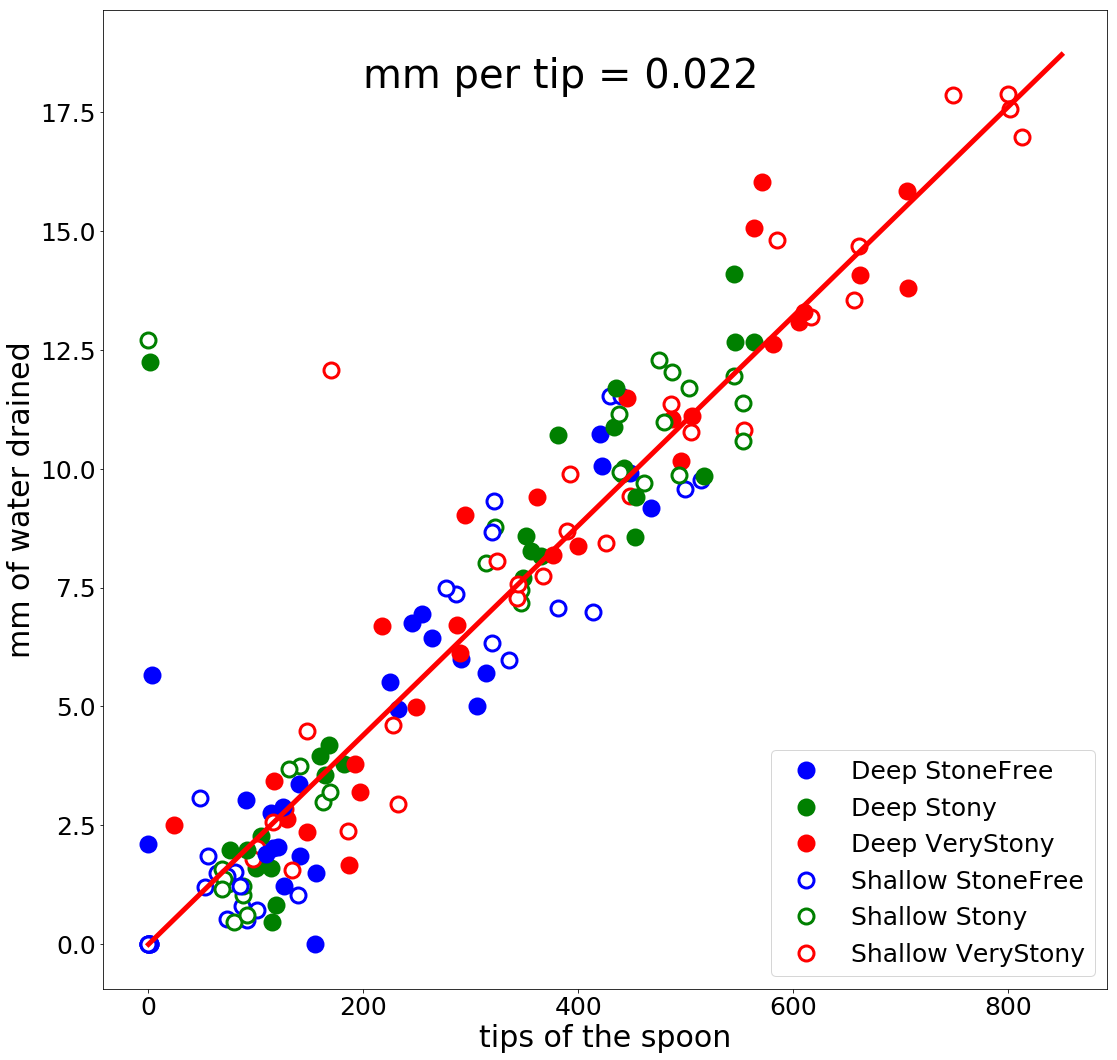

In [7]:
#area of the lysimeter
lysoArea = np.pi * np.power(0.25,2)

first = 15
last = 22
Observations = last - first
Observations = int(Observations)

fig = plt.figure(figsize=(18,18))

for obs in range(first,last):
    StartDate = ManualData.iloc[obs,:].name
    EndDate = ManualData.iloc[obs+1,:].name
    
    Gravels = ['Deep','Shallow']
    Stones = ['StoneFree','Stony','VeryStony']
    fills = ['b','g','r','w','w','w']
    colors = ['b','g','r']

    TreatPos = 0
    for Grav in Gravels:
        StonPos = 0
        for Ston in Stones:
            Tips = DrainageData.loc[StartDate:EndDate,(Grav,Ston)].sum(axis=0)
            #divide drainage by 1000 to convert to liters and divide by lysimeter area to convert to mm/m2
            #which is the same as mm drainage
            Drain = ManualData.loc[EndDate,(Grav,Ston)]/1000/lysoArea
            plt.plot(Tips,Drain,'o',markersize=15,mec = colors[StonPos],mfc = fills[TreatPos],mew=3, label = Grav+' ' +Ston)
            StonPos+=1
            TreatPos+=1
    if obs == 15:
        plt.legend(loc=4,numpoints=1,fontsize = 25)

mm_per_tip = .022
plt.plot([0,850],[0,850*mm_per_tip],'-',linewidth = 5,color='r')
plt.text(200,18,'mm per tip = '+str(mm_per_tip),fontsize=40)
plt.ylabel('mm of water drained', fontsize=30)
plt.xlabel('tips of the spoon', fontsize=30)
plt.tick_params(labelsize=25)


## Apply conversion

In [8]:
Drainage = DrainageData.multiply(mm_per_tip)
DrainageMeans = Drainage.groupby(level=['Gravels','Stones'],axis=1).mean()

In [9]:
Drainage.to_pickle('.\DataFrames\LysoDrainage_df')

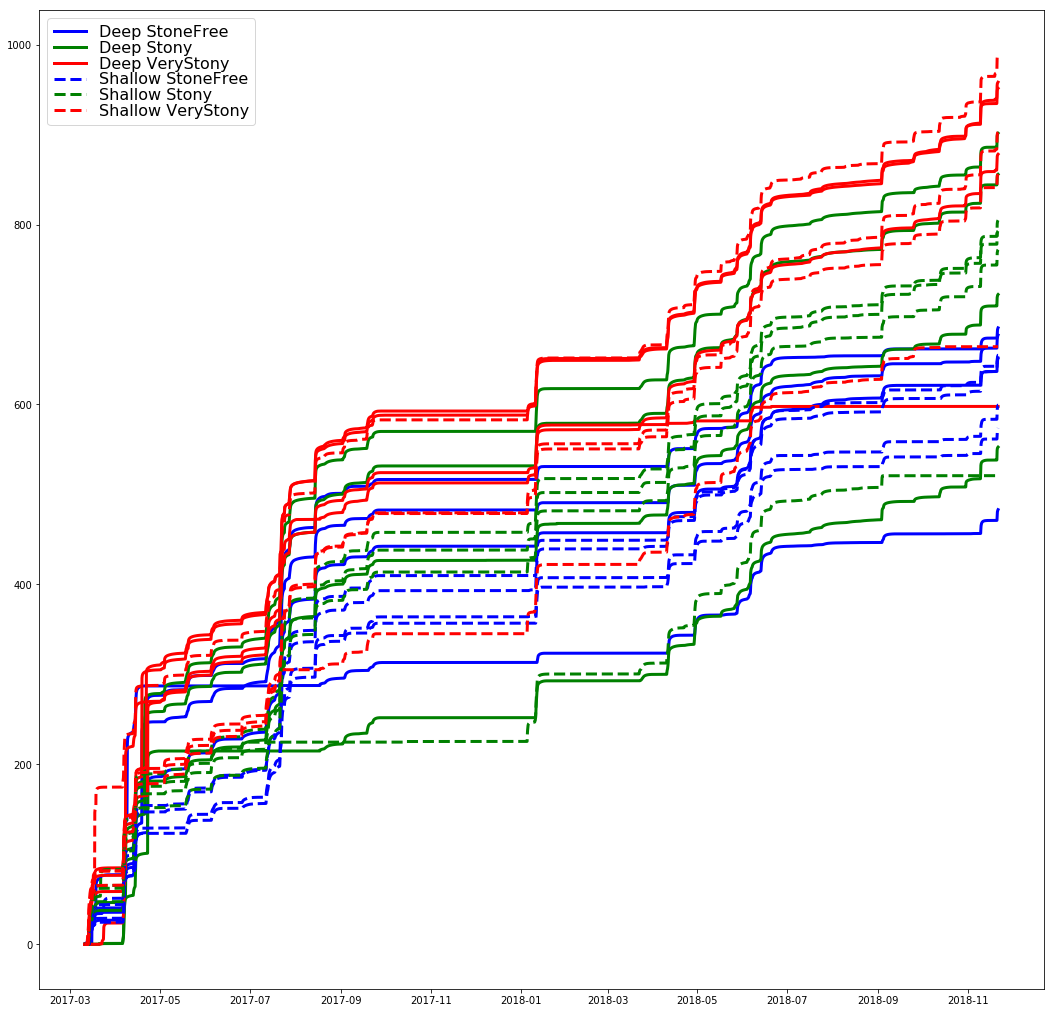

In [10]:
Graph = plt.figure(figsize=(18,18))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(Drainage.loc['2017-03-11':,:].cumsum(),ax,GPs,3)
plt.legend(loc=2,numpoints=1,fontsize = 15)
labels, handles = GH.DedupLegendElements()
ledg = plt.legend(labels, handles,loc=2,numpoints=1,fontsize = 16,labelspacing = 0.05)      

In [12]:
RecentAccum = Drainage.loc['2018-11-1':,:].cumsum()
RecentAccum.iloc[-1:,:].transpose()

2018-11-21 08:15:00
Gravels Stones    Treatment                     
Deep    StoneFree 10A                     29.942
                  16A                     26.686
                  23A                     23.342
                  6A                      29.678
        Stony     13B                     35.948
                  19B                     33.836
                  5B                      39.204
                  8B                      36.916
        VeryStony 11C                     41.756
                  15C                      0.000
                  24C                     48.070
                  4C                      45.496
Shallow StoneFree 14D                     28.864
                  20D                     35.552
                  2D                      40.348
                  7D                      30.954
        Stony     12E                     36.916
                  17E                     42.130
                  22E                      0.000
                  3E                      43.010
        VeryStony 18F                     38.500
                  1F                      53.548
                  21F                      0.000
                  9F                      48.356

In [15]:
Drainage.index.max()

Timestamp('2018-11-19 09:45:00')

C:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


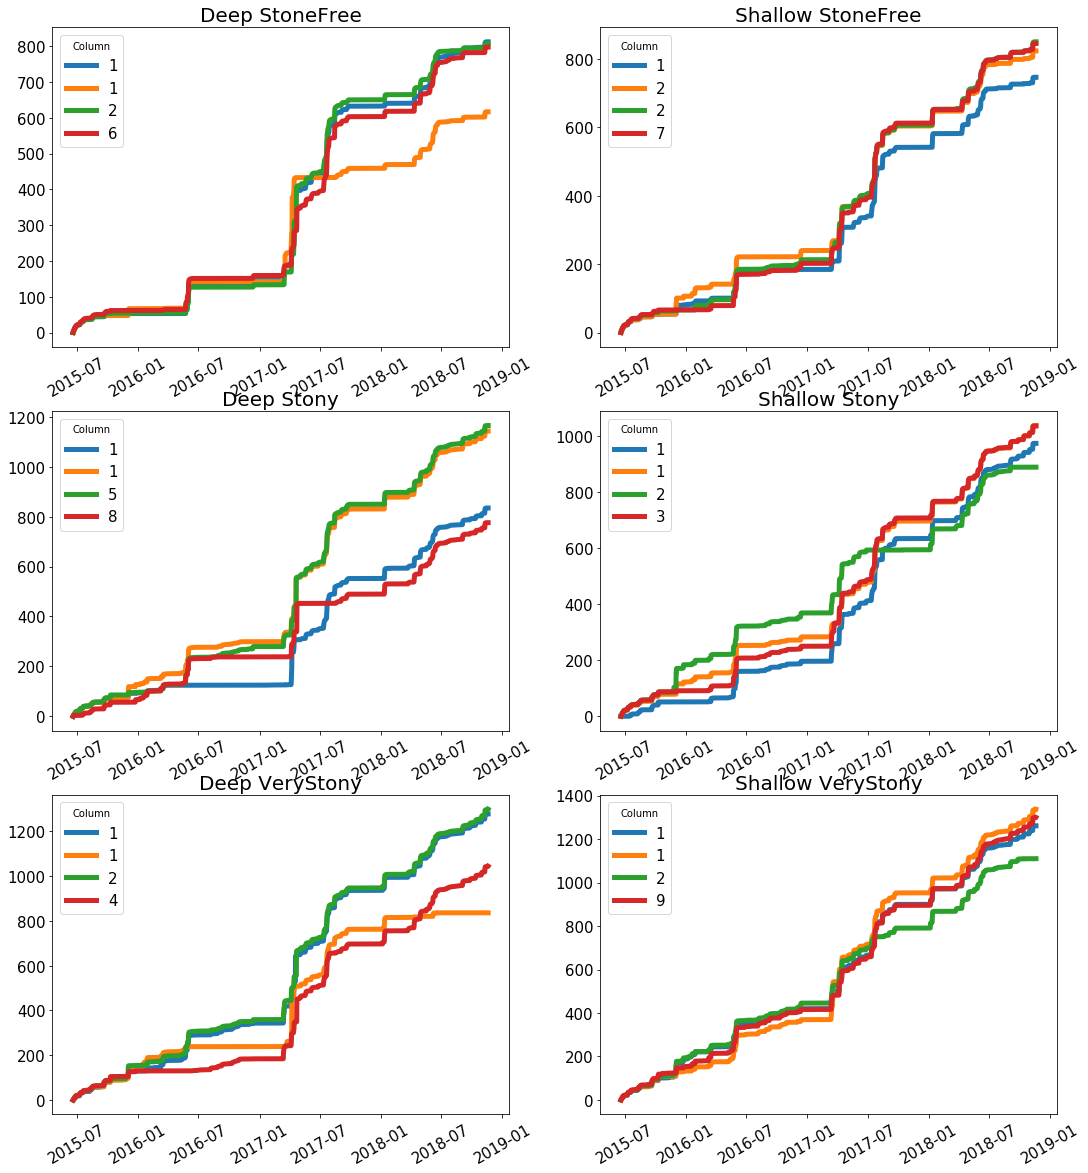

In [18]:
Gravels = ['Deep','Shallow']
Stones = ['StoneFree','Stony','VeryStony']
lines = ['-','--']
colors = ['b','g','r']

Graph = plt.figure(figsize=(18,20))

TreatPos = 1
for Ston in Stones:
    for Grav in Gravels:
        for rep in [0,1,2,3]:
            fig = Graph.add_subplot(3,2,TreatPos)
            Labels = Drainage.loc[:,(Grav,Ston)].iloc[:,rep].name[0]
            plt.plot(Drainage.loc[:,(Grav,Ston)].iloc[:,rep].index,
                     Drainage.loc[:,(Grav,Ston)].iloc[:,rep].cumsum(),
                    linewidth = 5, label = Labels)
            plt.title(Grav+' ' +Ston, fontsize=20)
            plt.xticks(rotation=30)
            plt.tick_params(labelsize=15)
        TreatPos += 1
        plt.legend(loc=2,numpoints=1,fontsize = 15,title='Column')
    GravPos +=1
Graph.savefig('Drainage.jpg')

## Some periods where individual spoons have stoped working.  Need to replace data for these periods with means

First of all identify periods where individual spoons are not working.  These are days when a certian spoon does not tip but all of the others in the same treatment do

In [19]:
#Replace Nan values with zero
Drainage.fillna(0,inplace=True)
#Calculate daily drainage sums
DailyDrainage = Drainage.resample('D').sum()
#Make a data frame to hold 0 if data good and 1 if the spoon was not working
MissingDataMask = Drainage.copy()
MissingDataMask.loc[:] = 0

In [20]:
for plot in Drainage.columns:
    for date in DailyDrainage.index:
        Today = date.date().strftime('%Y-%m-%d')
        Treatment = plot[0:2]
        PlotValue = DailyDrainage.loc[Today,plot]
        TreatValues = DailyDrainage.loc[Today,Treatment]
        DrainCount = sum(i>0 for i in TreatValues)
        TreatMean = np.mean(TreatValues)
        #if plot didn't record drainage today, but at least two other did, it may be faulty
        if (PlotValue == 0) and (DrainCount >= 2):
            #if only one spoon recorded no data today or two spoons recorded data 
            #and there was > 5mm high drainage in the other two assume spoon is faulty 
            if (DrainCount == 3) or (TreatMean > 2.5):
                #Mark this plot as not working for this period
                MissingDataMask.loc[Today,plot] = 1.0

## Clearly see periods where some spoons were not tipping when others were.  For these periods replace the zero drainage recorded for the faulty spoons with the treatment mean.

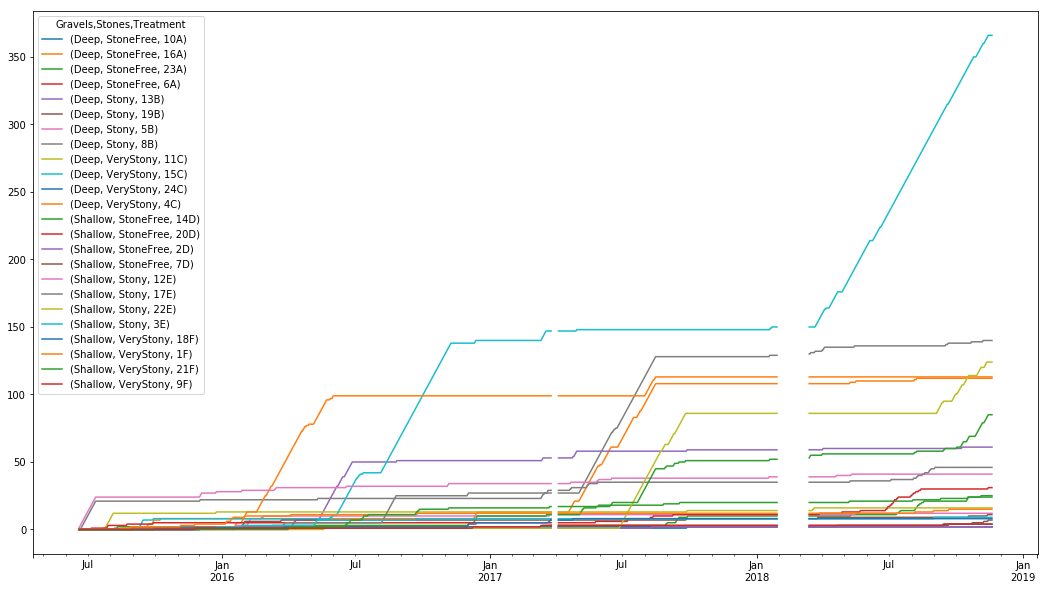

In [28]:
MissingDataMask.resample('D').mean().cumsum().plot(figsize=(18,10),legend=True)
#plt.ylim(-0.2,50)

## First of all we need to calculate a treatment mean that excludes zero values from faulty spoons.

This requires us to set drainage values to nan for periods when spoons were faulty

In [22]:
Drainage.where(MissingDataMask==0,np.nan,inplace=True)
TreatMeans = Drainage.groupby(level=['Gravels','Stones'],axis=1).mean()

### Then we replace the Na values with treatment means

In [23]:
for plot in Drainage.columns:
    Drainage.loc[:,plot].fillna(TreatMeans.loc[:,plot[0:2]],inplace=True)

### Finally, we zero the drainage for the period in March and April 2017 when Mina was applying treatments for her breakthrough measurements

In [24]:
Drainage.loc['2017-03-01':'2017-04-25',:] = 0

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

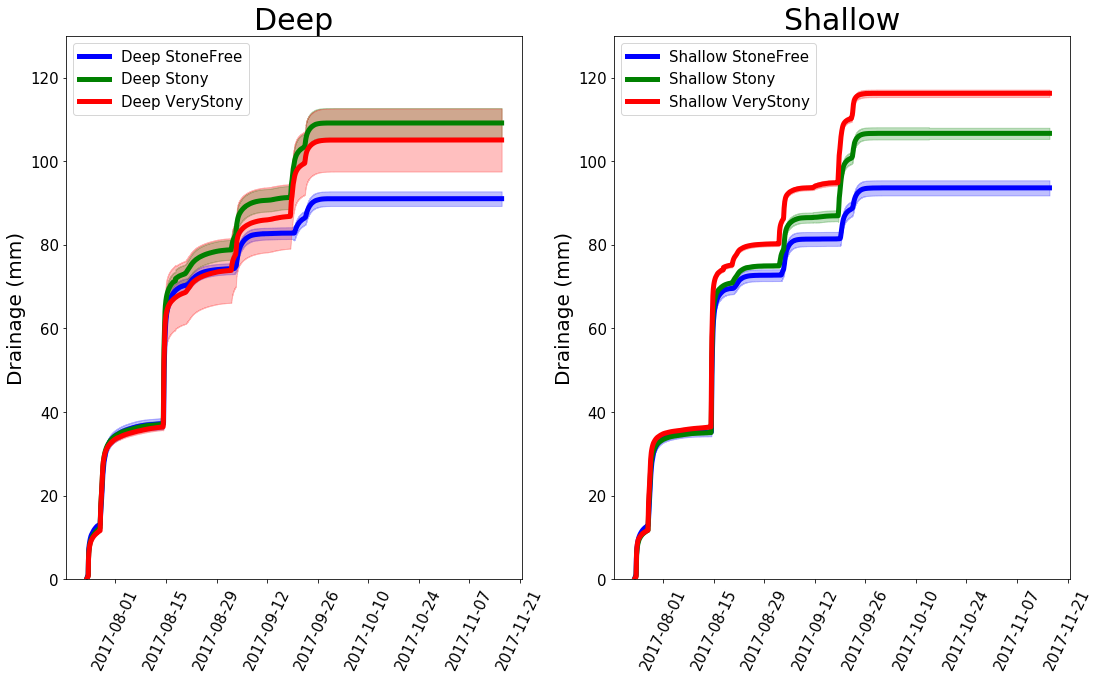

In [50]:
Gravels = ['Deep','Shallow']
Stones = ['StoneFree','Stony','VeryStony']
lines = ['-','--']
colors = ['b','g','r']

Graph = plt.figure(figsize=(18,10))

Start = '2017-07-24'
End = '2017-11-15'

GravPos = 0
for Grav in Gravels:
    fig = Graph.add_subplot(1,2,GravPos+1)
    StonPos = 0
    for Ston in Stones:
        median = Drainage.loc[Start:End,(Grav,Ston)].cumsum().median(axis=1)
        SEM = Drainage.loc[Start:End,(Grav,Ston)].cumsum().std(axis=1)/np.sqrt(4)
        Upper = median + SEM
        Lower = median - SEM
        plt.fill_between(Drainage.loc[Start:End,(Grav,Ston)].index,
                 Upper,
                 Lower,
                 color = colors[StonPos],alpha=0.25)
        plt.plot(Drainage.loc[Start:End,(Grav,Ston)].index,median,color=colors[StonPos],
                 linewidth = 5,
                 label = Grav+' ' +Ston)
        StonPos += 1
        plt.title(Grav, fontsize=30)
    GravPos +=1
    plt.ylim(0,130)
    plt.ylabel('Drainage (mm)', fontsize=20)
    plt.xticks(rotation=65)
    plt.tick_params(labelsize=15)    
    plt.legend(loc=2,numpoints=1,fontsize = 15)
plt.tight_layout

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

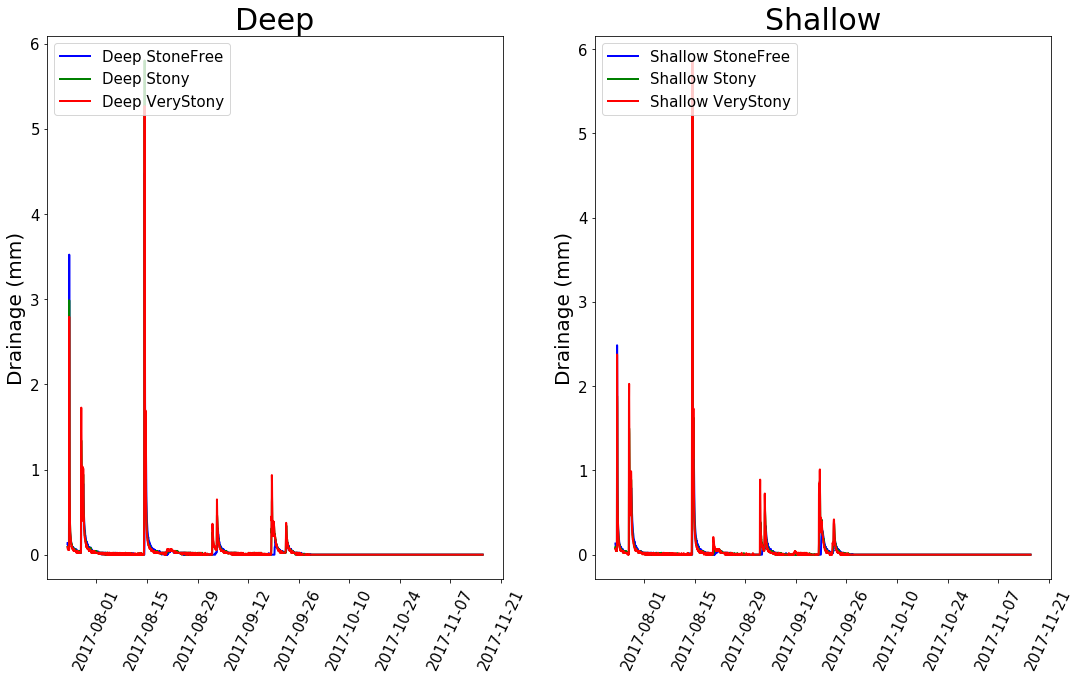

In [59]:
Gravels = ['Deep','Shallow']
Stones = ['StoneFree','Stony','VeryStony']
lines = ['-','--']
colors = ['b','g','r']

Graph = plt.figure(figsize=(18,10))

Start = '2017-07-24'
End = '2017-11-15'

GravPos = 0
for Grav in Gravels:
    fig = Graph.add_subplot(1,2,GravPos+1)
    StonPos = 0
    for Ston in Stones:
        median = Drainage.loc[Start:End,(Grav,Ston)].resample('h').sum().median(axis=1)
        #SEM = Drainage.loc[Start:End,(Grav,Ston)].std(axis=1)/np.sqrt(4)
        Upper = median + SEM
        Lower = median - SEM
        #plt.fill_between(Drainage.loc[Start:End,(Grav,Ston)].index,
        #         Upper,
        #         Lower,
        #         color = colors[StonPos],alpha=0.25)
        plt.plot(median.index,median,color=colors[StonPos],
                 linewidth = 2,
                 label = Grav+' ' +Ston)
        StonPos += 1
        plt.title(Grav, fontsize=30)
    GravPos +=1
    #plt.ylim(0,0.8)
    plt.ylabel('Drainage (mm/h)', fontsize=20)
    plt.xticks(rotation=65)
    plt.tick_params(labelsize=15)    
    plt.legend(loc=2,numpoints=1,fontsize = 15)
plt.tight_layout

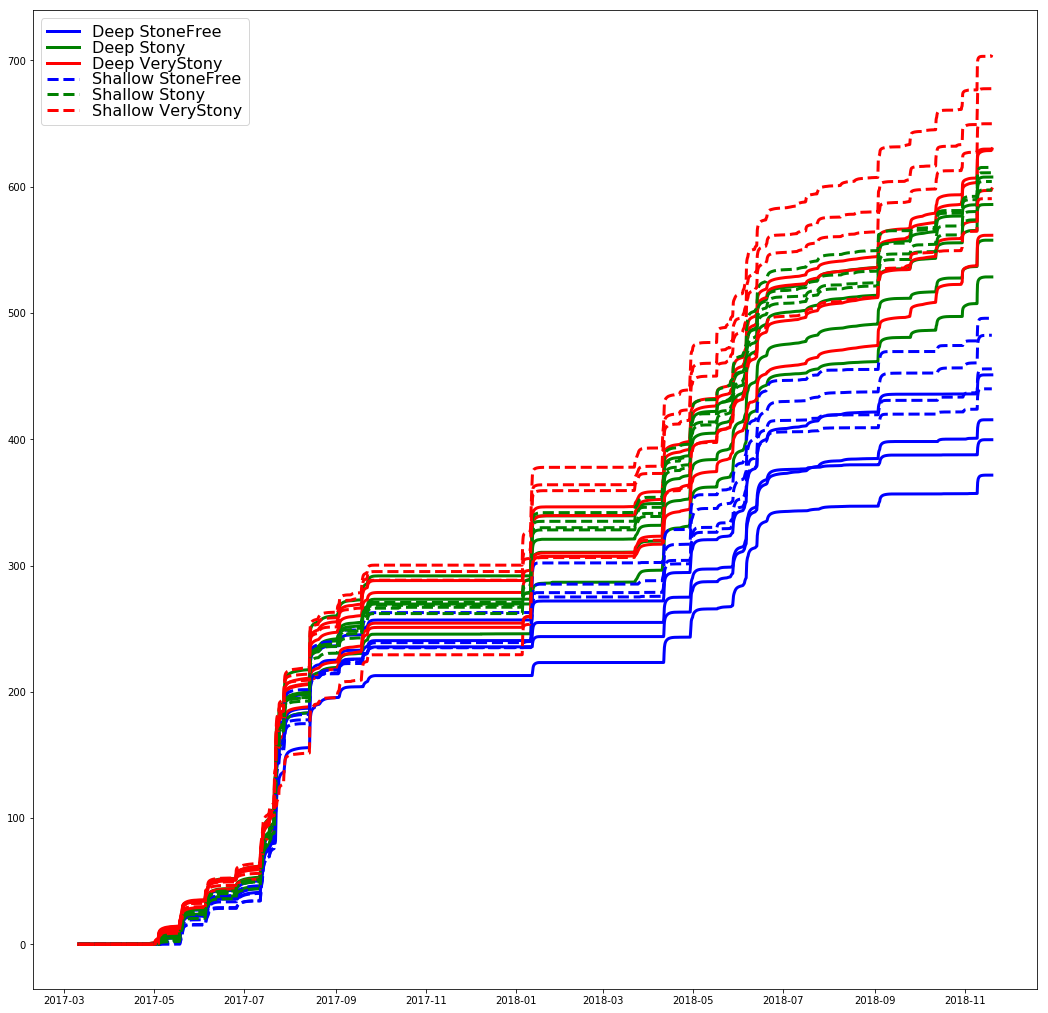

In [51]:
Graph = plt.figure(figsize=(18,18))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(Drainage.loc['2017-03-11':,:].cumsum(),ax,GPs,3)
plt.legend(loc=2,numpoints=1,fontsize = 15)
labels, handles = GH.DedupLegendElements()
ledg = plt.legend(labels, handles,loc=2,numpoints=1,fontsize = 16,labelspacing = 0.05)

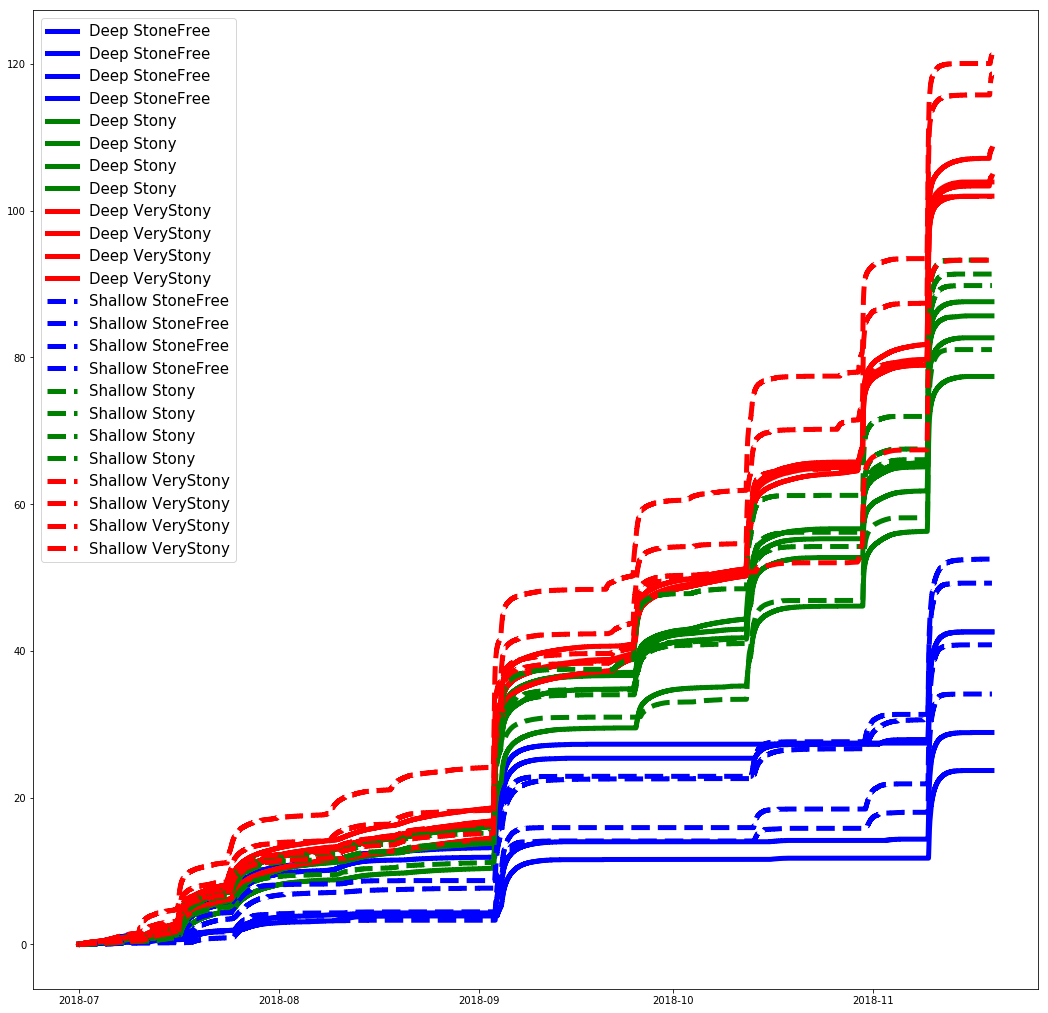

In [47]:
Gravels = ['Deep','Shallow']
Stones = ['StoneFree','Stony','VeryStony']
lines = ['-','--']
colors = ['b','g','r']

fig = plt.figure(figsize=(18,18))

GravPos = 0
for Grav in Gravels:
    StonPos = 0
    for Ston in Stones:
        plt.plot(Drainage.loc['2018-07-01':,(Grav,Ston)].index,
                 Drainage.loc['2018-07-01':,(Grav,Ston)].cumsum(),
                 lines[GravPos],
                color = colors[StonPos],
                linewidth = 5,
                label = Grav+' ' +Ston)
        StonPos += 1
    GravPos +=1
plt.legend(loc=2,numpoints=1,fontsize = 15)


In [52]:
DailyDrainage.to_pickle('.\Dataframes\Drainage')